In [76]:
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gradcam import get_img_array,make_gradcam_heatmap,save_and_display_gradcam

In [77]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

In [78]:
PATH = 'dataset/train/'

In [79]:
train_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 576 files for training.
['caribou', 'deer', 'elk', 'moose']


In [80]:
val_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 64 files for validation.
['caribou', 'deer', 'elk', 'moose']


In [81]:
test_ds = image_dataset_from_directory(
  'dataset/test/',
  seed=123,
  image_size=(224, 224))

print(test_ds.class_names)

Found 160 files belonging to 4 classes.


['caribou', 'deer', 'elk', 'moose']


In [82]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(224,224,3)),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest', name='rand_rot'),
                                          tf.keras.layers.RandomZoom(height_factor=0.1,fill_mode='nearest'),
                                          tf.keras.layers.RandomBrightness(0.2),
                                          tf.keras.layers.Rescaling(1./255)
                                      ],
                                     name='dataaug' )

In [83]:
c = 0
for x,y in train_ds:
    # print(x.shape)
    # print(x)
    # print(y)
    c += len(x)
print(c)

576


In [84]:
augmented_train = train_ds.map(lambda x,y: (dataaug(x,training=True),y))

2023-10-29 13:56:21.904274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


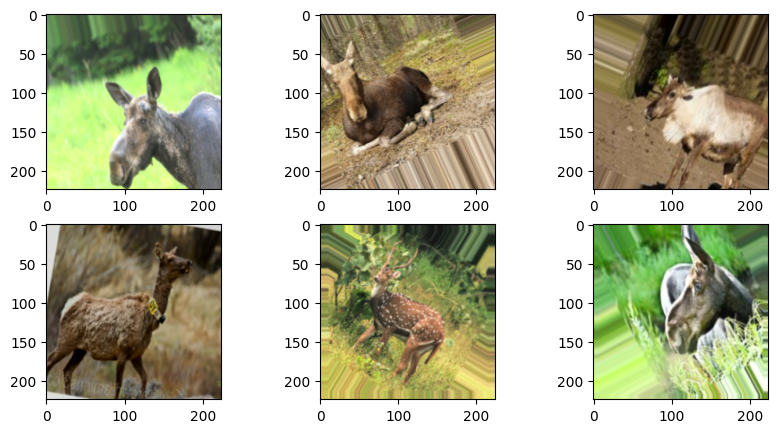

In [85]:
# show original vs resized
fig, ax = plt.subplots(2, 3, figsize=(10,5))
ax = ax.ravel()
for images, labels in augmented_train:
    for i in range(6):
        ax[i].imshow(images[i])

In [86]:
full_train_ds = train_ds.concatenate(augmented_train)

In [87]:
c = 0
for x,y in full_train_ds:
    c += len(x)
print(c)

2023-10-29 13:56:31.188823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1152


In [88]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = full_train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

In [89]:
def preprocess(images, labels):
  return preprocess_input(images), labels

train_dataset = train_dataset.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [90]:
base_model = ResNet152V2(input_shape=(224,224,3), 
                         include_top=False,
                         pooling='avg',
                         weights="imagenet")
base_model.trainable = False
for layer in base_model.layers:
    # if layer.name in ['conv5_block3_3_conv']:
    #     layer.trainable = True
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [91]:
for i,layer in enumerate(base_model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_8 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = True
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = True
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = True
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = True
Layer 18: name = conv2_block2_preac

In [92]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [93]:
# tf.keras.utils.plot_model(base_model, to_file='resnet_feature.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

In [94]:
base_model_output = base_model.output

x = tf.keras.layers.Flatten()(base_model_output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=new_outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [95]:
for i,layer in enumerate(model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_8 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = True
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = True
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = True
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = True
Layer 18: name = conv2_block2_preac

In [96]:
# Defining Callbacks

checkpoint_filepath = "resnet_callback/bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.weights.h5"

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(checkpoint_filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000025,verbose=1)
callback_list = [reduce_lr, checkpoint]

In [97]:
# Model Compile 

OPT    = tf.keras.optimizers.legacy.Adam(learning_rate=0.00005)

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [98]:
model_history=model.fit(train_dataset,
                        validation_data=val_ds,
                        epochs = 30,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/30


2023-10-29 13:57:00.338020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 8/36 [=====>........................] - ETA: 33s - loss: 2.2233 - accuracy: 0.2344

2023-10-29 13:58:26.193472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 2.0795 - accuracy: 0.2691

2023-10-29 13:58:53.855536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.32812, saving model to resnet_callback/bestmodel_epoch01_valloss1.70.weights.h5


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 146s 2s/step - loss: 2.0795 - accuracy: 0.2691 - val_loss: 1.6978 - val_accuracy: 0.3281 - lr: 5.0000e-05
Epoch 2/30
 8/36 [=====>........................] - ETA: 25s - loss: 1.7576 - accuracy: 0.3242

2023-10-29 13:59:31.868719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.8261 - accuracy: 0.3056
Epoch 2: val_accuracy improved from 0.32812 to 0.50000, saving model to resnet_callback/bestmodel_epoch02_valloss1.15.weights.h5
36/36 [==============================] - 39s 1s/step - loss: 1.8261 - accuracy: 0.3056 - val_loss: 1.1483 - val_accuracy: 0.5000 - lr: 5.0000e-05
Epoch 3/30
 8/36 [=====>........................] - ETA: 25s - loss: 1.6252 - accuracy: 0.3398

2023-10-29 14:00:10.048905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.6811 - accuracy: 0.3385
Epoch 3: val_accuracy improved from 0.50000 to 0.64062, saving model to resnet_callback/bestmodel_epoch03_valloss0.94.weights.h5
36/36 [==============================] - 38s 1s/step - loss: 1.6811 - accuracy: 0.3385 - val_loss: 0.9412 - val_accuracy: 0.6406 - lr: 5.0000e-05
Epoch 4/30
 8/36 [=====>........................] - ETA: 25s - loss: 1.4848 - accuracy: 0.4062

2023-10-29 14:00:48.003894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.5894 - accuracy: 0.3802
Epoch 4: val_accuracy improved from 0.64062 to 0.71875, saving model to resnet_callback/bestmodel_epoch04_valloss0.83.weights.h5
36/36 [==============================] - 38s 1s/step - loss: 1.5894 - accuracy: 0.3802 - val_loss: 0.8277 - val_accuracy: 0.7188 - lr: 5.0000e-05
Epoch 5/30
 8/36 [=====>........................] - ETA: 26s - loss: 1.5076 - accuracy: 0.3594

2023-10-29 14:01:26.279257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.5199 - accuracy: 0.3507
Epoch 5: val_accuracy improved from 0.71875 to 0.76562, saving model to resnet_callback/bestmodel_epoch05_valloss0.77.weights.h5
36/36 [==============================] - 38s 1s/step - loss: 1.5199 - accuracy: 0.3507 - val_loss: 0.7683 - val_accuracy: 0.7656 - lr: 5.0000e-05
Epoch 6/30
 8/36 [=====>........................] - ETA: 25s - loss: 1.3258 - accuracy: 0.4688

2023-10-29 14:02:04.276824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.4321 - accuracy: 0.4054
Epoch 6: val_accuracy improved from 0.76562 to 0.79688, saving model to resnet_callback/bestmodel_epoch06_valloss0.73.weights.h5
36/36 [==============================] - 38s 1s/step - loss: 1.4321 - accuracy: 0.4054 - val_loss: 0.7347 - val_accuracy: 0.7969 - lr: 5.0000e-05
Epoch 7/30
 8/36 [=====>........................] - ETA: 25s - loss: 1.2391 - accuracy: 0.4922

2023-10-29 14:02:42.933598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.4387 - accuracy: 0.4149
Epoch 7: val_accuracy did not improve from 0.79688
36/36 [==============================] - 37s 965ms/step - loss: 1.4387 - accuracy: 0.4149 - val_loss: 0.7246 - val_accuracy: 0.7656 - lr: 5.0000e-05
Epoch 8/30
 8/36 [=====>........................] - ETA: 24s - loss: 1.2287 - accuracy: 0.4844

2023-10-29 14:03:18.810568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.3337 - accuracy: 0.4444
Epoch 8: val_accuracy did not improve from 0.79688
36/36 [==============================] - 37s 982ms/step - loss: 1.3337 - accuracy: 0.4444 - val_loss: 0.7084 - val_accuracy: 0.7812 - lr: 5.0000e-05
Epoch 9/30
 8/36 [=====>........................] - ETA: 25s - loss: 1.2653 - accuracy: 0.4688

2023-10-29 14:03:56.297748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.3113 - accuracy: 0.4583
Epoch 9: val_accuracy did not improve from 0.79688
36/36 [==============================] - 37s 977ms/step - loss: 1.3113 - accuracy: 0.4583 - val_loss: 0.7089 - val_accuracy: 0.7969 - lr: 5.0000e-05
Epoch 10/30
 8/36 [=====>........................] - ETA: 24s - loss: 1.0038 - accuracy: 0.5977

2023-10-29 14:04:32.444941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.2122 - accuracy: 0.5156
Epoch 10: val_accuracy improved from 0.79688 to 0.81250, saving model to resnet_callback/bestmodel_epoch10_valloss0.70.weights.h5
36/36 [==============================] - 38s 1s/step - loss: 1.2122 - accuracy: 0.5156 - val_loss: 0.6951 - val_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 11/30
 8/36 [=====>........................] - ETA: 25s - loss: 1.0509 - accuracy: 0.5547

2023-10-29 14:05:10.838323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.2019 - accuracy: 0.5017
Epoch 11: val_accuracy did not improve from 0.81250
36/36 [==============================] - 37s 972ms/step - loss: 1.2019 - accuracy: 0.5017 - val_loss: 0.6885 - val_accuracy: 0.7969 - lr: 5.0000e-05
Epoch 12/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.9230 - accuracy: 0.6250

2023-10-29 14:05:46.748029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.1653 - accuracy: 0.5156
Epoch 12: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 965ms/step - loss: 1.1653 - accuracy: 0.5156 - val_loss: 0.6813 - val_accuracy: 0.7969 - lr: 5.0000e-05
Epoch 13/30
 8/36 [=====>........................] - ETA: 25s - loss: 1.0135 - accuracy: 0.5977

2023-10-29 14:06:22.914574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.1771 - accuracy: 0.5078
Epoch 13: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 969ms/step - loss: 1.1771 - accuracy: 0.5078 - val_loss: 0.6786 - val_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 14/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.9418 - accuracy: 0.6523

2023-10-29 14:06:58.964072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.1794 - accuracy: 0.5200
Epoch 14: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 960ms/step - loss: 1.1794 - accuracy: 0.5200 - val_loss: 0.6792 - val_accuracy: 0.7969 - lr: 5.0000e-05
Epoch 15/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.9476 - accuracy: 0.5977

2023-10-29 14:07:34.901938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.1534 - accuracy: 0.5078
Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 15: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 964ms/step - loss: 1.1534 - accuracy: 0.5078 - val_loss: 0.6844 - val_accuracy: 0.7812 - lr: 5.0000e-05
Epoch 16/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8460 - accuracy: 0.6680

2023-10-29 14:08:10.861081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0875 - accuracy: 0.5556
Epoch 16: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 966ms/step - loss: 1.0875 - accuracy: 0.5556 - val_loss: 0.6838 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 17/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8823 - accuracy: 0.6250

2023-10-29 14:08:47.061818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.1073 - accuracy: 0.5477
Epoch 17: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 962ms/step - loss: 1.1073 - accuracy: 0.5477 - val_loss: 0.6802 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 18/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.9074 - accuracy: 0.6445

2023-10-29 14:09:23.099961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0904 - accuracy: 0.5547
Epoch 18: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 964ms/step - loss: 1.0904 - accuracy: 0.5547 - val_loss: 0.6785 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 19/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8164 - accuracy: 0.6836

2023-10-29 14:09:59.053381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0925 - accuracy: 0.5521
Epoch 19: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 963ms/step - loss: 1.0925 - accuracy: 0.5521 - val_loss: 0.6763 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 20/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8930 - accuracy: 0.6562

2023-10-29 14:10:35.209295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.1199 - accuracy: 0.5477
Epoch 20: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 964ms/step - loss: 1.1199 - accuracy: 0.5477 - val_loss: 0.6749 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 21/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8206 - accuracy: 0.6680

2023-10-29 14:11:11.251225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0889 - accuracy: 0.5391
Epoch 21: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 963ms/step - loss: 1.0889 - accuracy: 0.5391 - val_loss: 0.6754 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 22/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8437 - accuracy: 0.6484

2023-10-29 14:11:47.229812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.5573
Epoch 22: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 963ms/step - loss: 1.0962 - accuracy: 0.5573 - val_loss: 0.6710 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 23/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8317 - accuracy: 0.6680

2023-10-29 14:12:23.539411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.5694
Epoch 23: val_accuracy did not improve from 0.81250
36/36 [==============================] - 37s 992ms/step - loss: 1.0614 - accuracy: 0.5694 - val_loss: 0.6713 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 24/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8764 - accuracy: 0.6562

2023-10-29 14:13:00.506206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0885 - accuracy: 0.5825
Epoch 24: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 968ms/step - loss: 1.0885 - accuracy: 0.5825 - val_loss: 0.6675 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 25/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8614 - accuracy: 0.6562

2023-10-29 14:13:36.594016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0632 - accuracy: 0.5547
Epoch 25: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 959ms/step - loss: 1.0632 - accuracy: 0.5547 - val_loss: 0.6661 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 26/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.7865 - accuracy: 0.6836

2023-10-29 14:14:12.419830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0913 - accuracy: 0.5564
Epoch 26: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 961ms/step - loss: 1.0913 - accuracy: 0.5564 - val_loss: 0.6664 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 27/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.8635 - accuracy: 0.6562

2023-10-29 14:14:48.346089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.1046 - accuracy: 0.5521
Epoch 27: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 966ms/step - loss: 1.1046 - accuracy: 0.5521 - val_loss: 0.6645 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 28/30
 8/36 [=====>........................] - ETA: 25s - loss: 0.8456 - accuracy: 0.6367

2023-10-29 14:15:24.527582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0652 - accuracy: 0.5651
Epoch 28: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 967ms/step - loss: 1.0652 - accuracy: 0.5651 - val_loss: 0.6619 - val_accuracy: 0.7656 - lr: 1.0000e-05
Epoch 29/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.7857 - accuracy: 0.6797

2023-10-29 14:16:00.482815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0485 - accuracy: 0.5799
Epoch 29: val_accuracy did not improve from 0.81250
36/36 [==============================] - 36s 962ms/step - loss: 1.0485 - accuracy: 0.5799 - val_loss: 0.6626 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 30/30
 8/36 [=====>........................] - ETA: 24s - loss: 0.7692 - accuracy: 0.6758

2023-10-29 14:16:36.479213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 1.0815 - accuracy: 0.5582
Epoch 30: val_accuracy did not improve from 0.81250
36/36 [==============================] - 37s 989ms/step - loss: 1.0815 - accuracy: 0.5582 - val_loss: 0.6603 - val_accuracy: 0.7812 - lr: 1.0000e-05


In [110]:
history = model_history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

Text(0, 0.5, 'Accuracy')

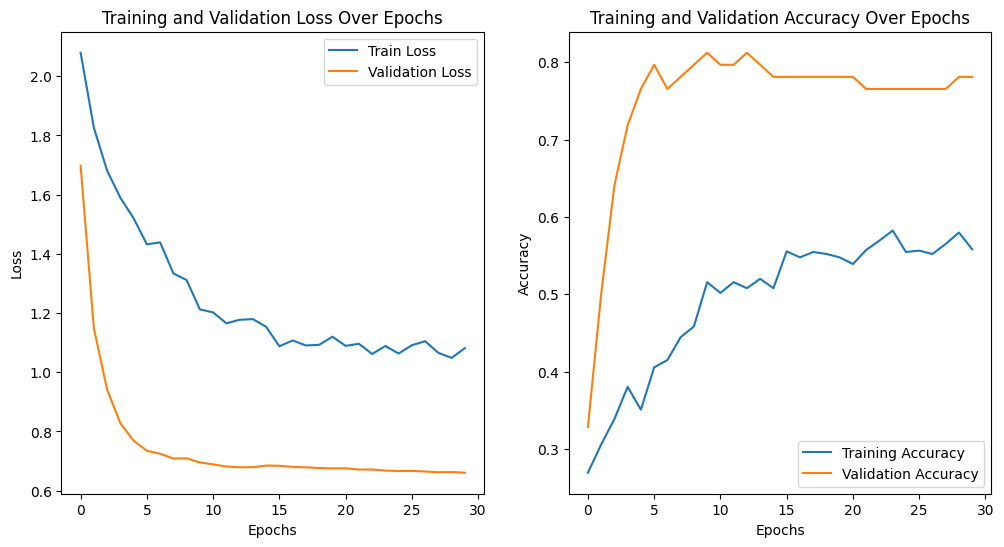

In [111]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [112]:
test_result = model.evaluate(test_ds)
print(f'{model.metrics_names}: {test_result}')

5/5 [==============================] - 3s 387ms/step - loss: 0.6766 - accuracy: 0.7812
['loss', 'accuracy']: [0.6765750646591187, 0.78125]


In [102]:
last_conv_layer_name = "conv5_block3_out"

In [103]:
grad_cam_img_path = 'dataset/train/deer/fallow_deer_4.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, base_model, last_conv_layer_name)

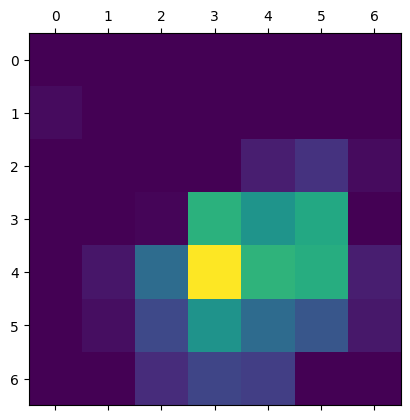

In [104]:
plt.matshow(heatmap)
plt.show()

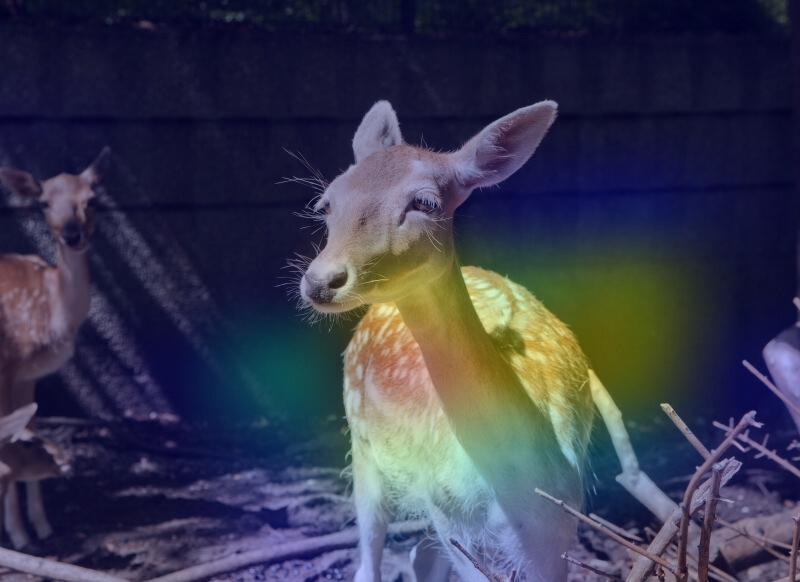

In [105]:
save_and_display_gradcam(grad_cam_img_path, heatmap)

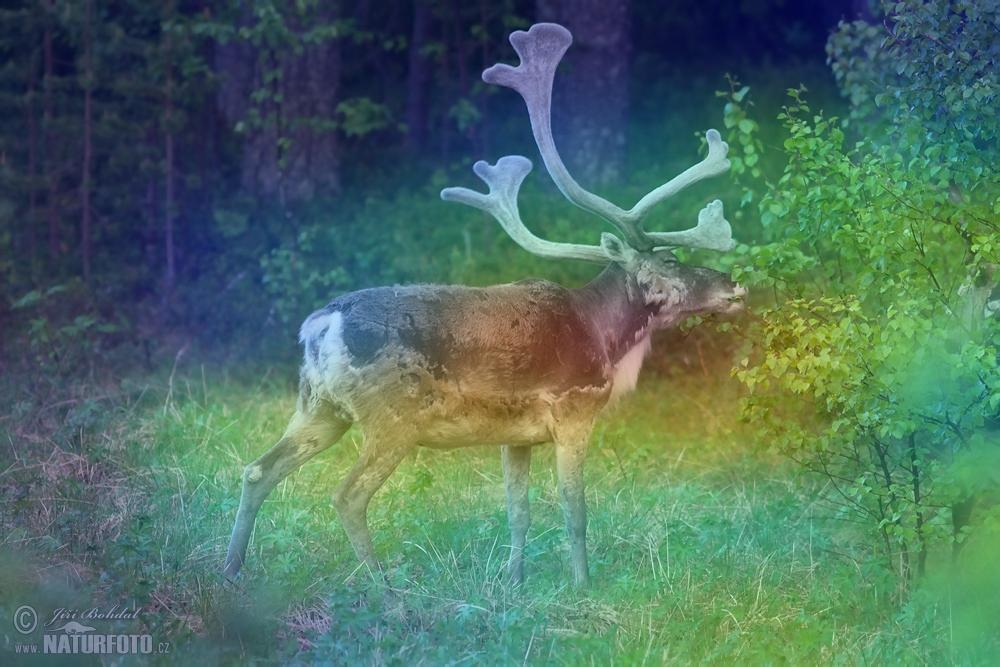

In [106]:
grad_cam_img_path = 'dataset/train/caribou/Male_Caribou56.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, base_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

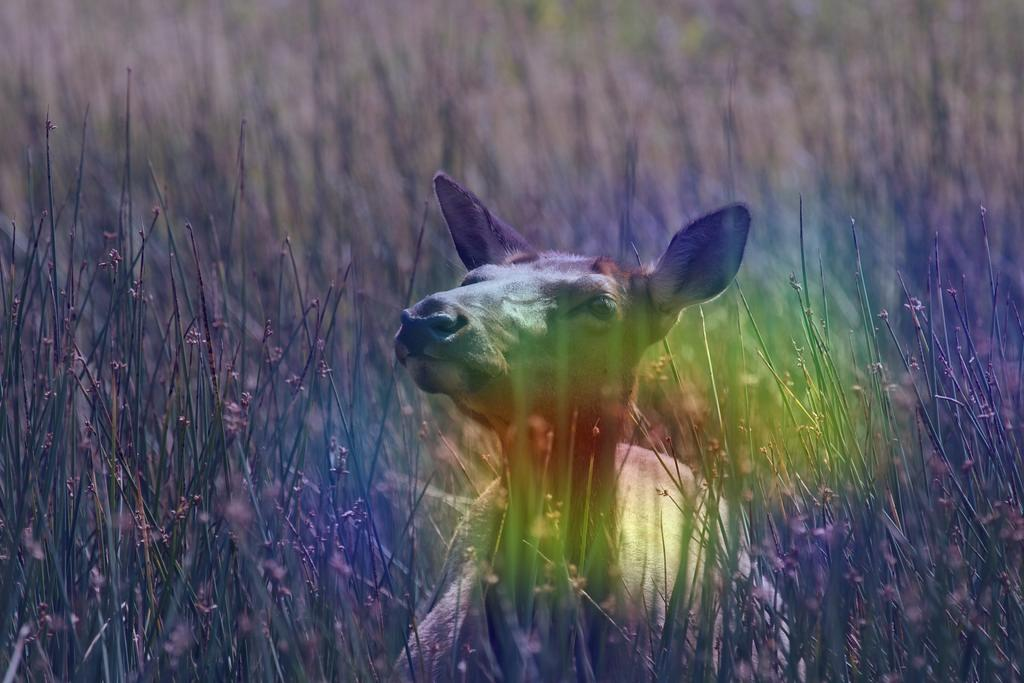

In [107]:
grad_cam_img_path = 'dataset/train/elk/EDF9.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, base_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

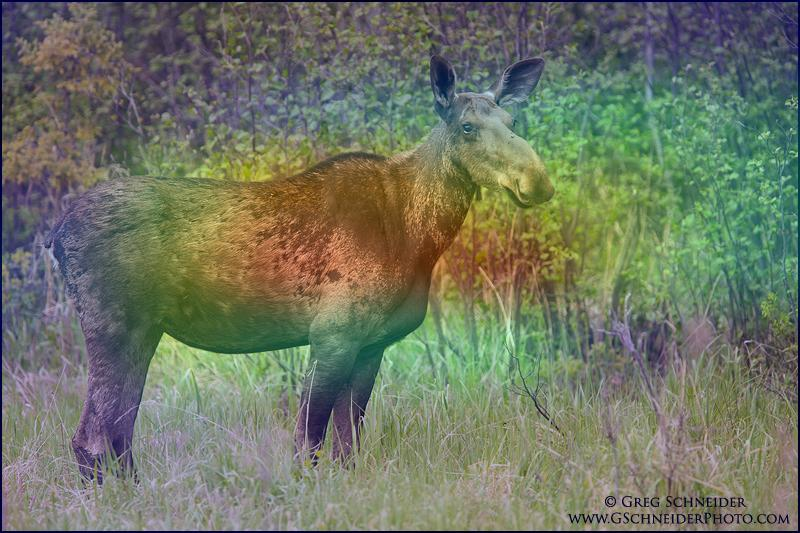

In [108]:

grad_cam_img_path = 'dataset/train/moose/female_moose (23).jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, base_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

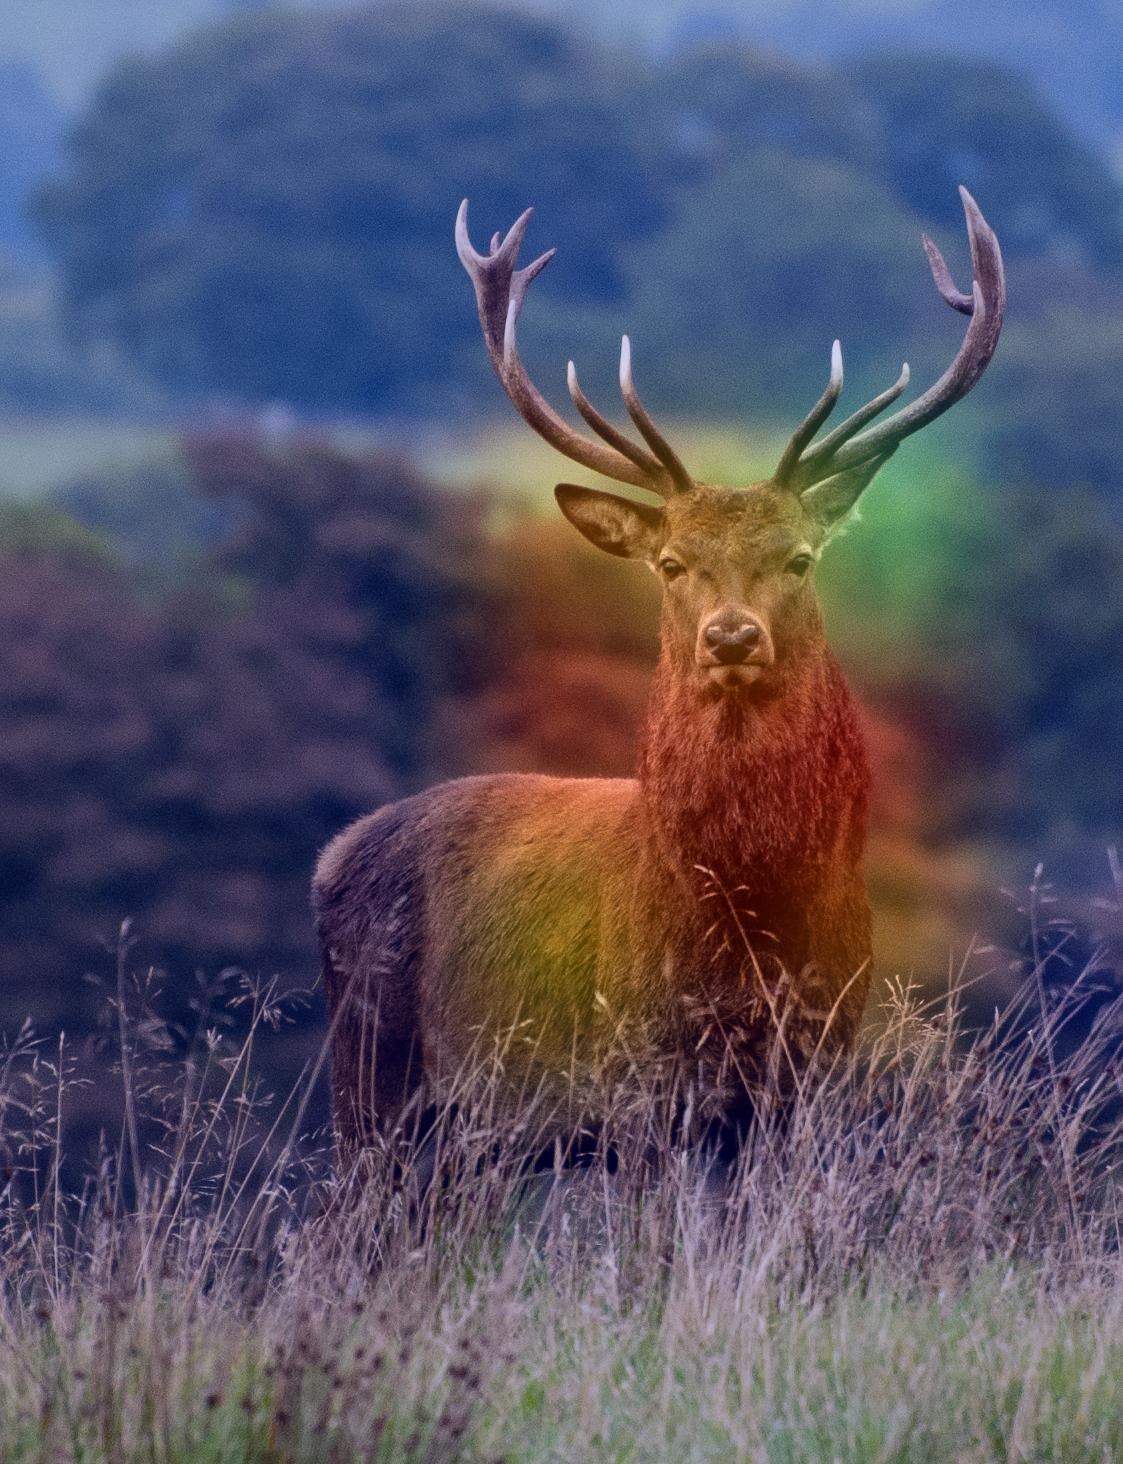

In [109]:

grad_cam_img_path = 'dataset/test/deer/red_deer_00044.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, base_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)